## IMDB Movie Analysis 

### Objective 
To explore the dataset and determine interesting relationships between the variables present in the dataset. 


### Questions 
Possible questions that may naturally arise from exploration:
- Does director popularity or actor popularity increase movie ratings and gross earnings? 
- Do critic reviews have a stronger relationship than user reviews with the sucess or quality of movies? 
- Does budget correlate with the quality or success with movies? 
- Are certain genres more popular than others? 


### Dataset 
The dataset was taken from [data.world](https://data.world/popculture/imdb-5000-movie-dataset). Thanks to Chuan Sun for providing the dataset. 

In [1]:
# Python 3.7
# Import Basic Libraries
import regex
import math
import pandas as pd
import numpy as np
import os 
import random 
import shutil 
import datetime
import calendar
import copy
from collections import namedtuple, Counter
from urllib      import parse
import statsmodels.formula.api as smf
import statsmodels.api as sm

np.random.seed(2019)         #Set seed so we can make it as reproducible as it can be. 

# Set Pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Machine Learning Library
from sklearn                 import preprocessing
from sklearn.metrics         import mean_squared_error, mean_absolute_error
        
        
# Import Visualization Libraries
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns 
from cycler              import cycler



# Reset Defaults Style for Matplotlib
plt.rcParams.update(plt.rcParamsDefault)

# Set Defaults for Seaborn
sns.set(color_codes=True)

# Allows you to actually see the graphs in the notebook
%matplotlib inline   

# Set Defaults for Matplotlib
# Information about how to change defaults is here:
# https://matplotlib.org/tutorials/introductory/customizing.html#sphx-glr-tutorials-introductory-customizing-py
mpl.style.use(style = 'seaborn-whitegrid')
#mpl.rcParams['figure.figsize'] = [13.333, 7.5] # for powerpoint presentations
mpl.rcParams['figure.figsize'] = [18, 10]
mpl.rcParams['figure.dpi']     = 80
mpl.rcParams['savefig.dpi']    = 100
mpl.rcParams['grid.color'] = '#DCDCDC'
mpl.rcParams['savefig.facecolor'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#ffffff'
mpl.rcParams['axes.facecolor'] = '#ffffff'
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#D55E00'])
available_colors = list(sns.colors.crayons.values())
available_palettes = list(sns.palettes.SEABORN_PALETTES.keys())

In [2]:
# Load the data 
movie_df = pd.read_csv('../data/movie_metadata.csv')

In [3]:
# Let's take a look at the data types
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [4]:
# Check the null ratios to see if there are variables that suffer from a lot of null values.
movie_df.isna().mean().round(4).sort_values() * 100

cast_total_facebook_likes     0.00
imdb_score                    0.00
movie_imdb_link               0.00
num_voted_users               0.00
movie_title                   0.00
genres                        0.00
movie_facebook_likes          0.00
country                       0.10
actor_1_facebook_likes        0.14
actor_1_name                  0.14
language                      0.24
actor_2_facebook_likes        0.26
actor_2_name                  0.26
facenumber_in_poster          0.26
duration                      0.30
color                         0.38
num_user_for_reviews          0.42
actor_3_facebook_likes        0.46
actor_3_name                  0.46
num_critic_for_reviews        0.99
director_facebook_likes       2.06
director_name                 2.06
title_year                    2.14
plot_keywords                 3.03
content_rating                6.01
aspect_ratio                  6.52
budget                        9.76
gross                        17.53
dtype: float64

In [5]:
# Let's look at the stats (mean, mix, max, etc.)
# Check for abnormal values like a negative duration or negative facebook likes or really high numbers
movie_df.describe()

# Oddities
# The max aspect ratio is 16, which is the universal aspect ratio for television. There are possibly some tv movies in this dataset.
# The 1.22 billion dollar budget seems a little high. It's possible that the currency is not USD. 
# The max duration is 511 minutes, which is 8.51 hours. 
# In addition to the variables mentioned above, the numerical values seem skewed.

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


### Validate Dataset

Check for abnormalities and potential outliers. Use your best judgement, domain knowledge, and the internet to determine if they are mistakes. 

In [6]:
# Check value for duration
movie_df.query('duration == duration.max()')

# According to the link at movie_imdb_link, this is a TV series. We should delete/disregard it.
movie_df.drop(labels = movie_df.query('duration == duration.max()').index, inplace = True)

In [7]:
# Check 1.22 billion dollar budget
movie_df.query('budget == budget.max()')

# This budget is given in South Korean won, not USD. 
# This example makes it clear that we cannot entirely trust the monetary variables. 

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
2988,Color,Joon-ho Bong,363.0,110.0,584.0,74.0,Kang-ho Song,629.0,2201412.0,Comedy|Drama|Horror|Sci-Fi,Doona Bae,The Host,68883,1173,Ah-sung Ko,0.0,daughter|han river|monster|river|seoul,http://www.imdb.com/title/tt0468492/?ref_=fn_t...,279.0,Korean,South Korea,R,1.221550e+10,2006.0,398.0,7.0,1.85,7000


In [8]:
# Check the 16 aspect ratio 
movie_df.query('aspect_ratio == aspect_ratio.max()')

# If you look at the content rating, some of it is TV specific and some are tv shows. Again, we need to be careful.
# Drop anything that has an aspect ratio of 16 or greater.
movie_df.drop(labels = movie_df.query('aspect_ratio >= 16').index, 
              inplace = True)

In [9]:
# Drop TV records 
movie_df = movie_df[~movie_df['content_rating'].str.contains('TV', na = False, regex=False)]

In [10]:
# Check for duplicates
# Best way to check is by checking the movie_title 
movie_df.groupby('movie_title')['movie_facebook_likes'].agg(['count']).sort_values('count', ascending = False).head(20)

,count
movie_title,
The Fast and the Furious,3
Ben-Hur,3
Home,3
Pan,3
Victor Frankenstein,3
Halloween,3
King Kong,3
History of the World: Part I,2
Oz the Great and Powerful,2


In [11]:
# There are some movies that look like they could be part of a franchise. Still, we should check just in case.
# To be fair, duplicates do not seem common. 

# Checking duplicates
movie_df[movie_df['movie_title'].str.contains('Eddie the Eagle')]

# Everything is the same except for num_voted_users, the link is even the same. 

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1944,Color,Dexter Fletcher,216.0,106.0,452.0,141.0,Taron Egerton,20000.0,15785632.0,Biography|Comedy|Drama|Sport,Hugh Jackman,Eddie the Eagle,32507,21195,Tim McInnerny,3.0,1988 winter olympics|coach|ski jumper|winter|w...,http://www.imdb.com/title/tt1083452/?ref_=fn_t...,119.0,English,UK,PG-13,23000000.0,2016.0,732.0,7.5,2.35,15000
2059,Color,Dexter Fletcher,216.0,106.0,452.0,141.0,Taron Egerton,20000.0,15785632.0,Biography|Comedy|Drama|Sport,Hugh Jackman,Eddie the Eagle,32513,21195,Tim McInnerny,3.0,1988 winter olympics|coach|ski jumper|winter|w...,http://www.imdb.com/title/tt1083452/?ref_=fn_t...,119.0,English,UK,PG-13,23000000.0,2016.0,732.0,7.5,2.35,15000


In [12]:
# Checking duplicates
movie_df[movie_df['movie_title'].str.contains('Pan')]

# Pan films look different. 

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
139,Color,Jennifer Yuh Nelson,284.0,90.0,90.0,15.0,Gary Oldman,11000.0,165230261.0,Action|Adventure|Animation|Comedy|Family,Angelina Jolie Pitt,Kung Fu Panda 2,182718,21015,Mike Bell,0.0,china|kung fu|panda|peacock|tigress,http://www.imdb.com/title/tt1302011/?ref_=fn_t...,209.0,English,USA,PG,150000000.0,2011.0,10000.0,7.3,2.35,20000
145,Color,Joe Wright,256.0,111.0,456.0,394.0,Cara Delevingne,20000.0,34964818.0,Adventure|Family|Fantasy,Hugh Jackman,Pan,39956,21393,Nonso Anozie,4.0,1940s|child hero|fantasy world|orphan|referenc...,http://www.imdb.com/title/tt3332064/?ref_=fn_t...,186.0,English,USA,PG,150000000.0,2015.0,548.0,5.8,2.35,24000
154,Color,Alessandro Carloni,210.0,95.0,5.0,967.0,Angelina Jolie Pitt,24000.0,143523463.0,Action|Adventure|Animation|Comedy|Family,J.K. Simmons,Kung Fu Panda 3,64322,36095,Wayne Knight,0.0,china|kung fu|panda|pig|village,http://www.imdb.com/title/tt2267968/?ref_=fn_t...,145.0,English,USA,PG,145000000.0,2016.0,11000.0,7.2,2.35,24000
184,Color,Mark Osborne,266.0,92.0,54.0,562.0,Wayne Knight,11000.0,215395021.0,Action|Adventure|Animation|Comedy|Family,Angelina Jolie Pitt,Kung Fu Panda,307029,12754,Dan Fogler,0.0,kung fu|kung fu master|master|panda|snow leopard,http://www.imdb.com/title/tt0441773/?ref_=fn_t...,360.0,English,USA,PG,130000000.0,2008.0,967.0,7.6,2.35,6000
303,Color,Joe Wright,256.0,111.0,456.0,394.0,Cara Delevingne,20000.0,34964818.0,Adventure|Family|Fantasy,Hugh Jackman,Pan,39956,21393,Nonso Anozie,4.0,1940s|child hero|fantasy world|orphan|referenc...,http://www.imdb.com/title/tt3332064/?ref_=fn_t...,186.0,English,USA,PG,150000000.0,2015.0,548.0,5.8,2.35,24000
467,Color,Shawn Levy,147.0,93.0,189.0,38.0,Henry Czerny,1000.0,82226474.0,Adventure|Comedy|Crime|Family|Mystery,Roger Rees,The Pink Panther,65499,1267,William Abadie,0.0,diamond|france|investigation|pink panther|soccer,http://www.imdb.com/title/tt0383216/?ref_=fn_t...,424.0,English,USA,PG,65000000.0,2006.0,177.0,5.6,1.85,0
1043,Color,David Fincher,233.0,112.0,21000.0,237.0,Dwight Yoakam,17000.0,95308367.0,Crime|Drama|Thriller,Kristen Stewart,Panic Room,206104,18141,Mel Rodriguez,0.0,brownstone|burglar|money|panic|panic room,http://www.imdb.com/title/tt0258000/?ref_=fn_t...,850.0,English,USA,R,48000000.0,2002.0,324.0,6.8,2.35,0
1310,Color,Christian Alvart,219.0,108.0,22.0,61.0,Dennis Quaid,12000.0,10326062.0,Action|Horror|Mystery|Sci-Fi|Thriller,Norman Reedus,Pandorum,121432,14127,Eddie Rouse,0.0,future|mission|space|spaceship|survival,http://www.imdb.com/title/tt1188729/?ref_=fn_t...,310.0,English,Germany,R,33000000.0,2009.0,2000.0,6.8,2.35,10000
1602,Color,Stephen Hillenburg,89.0,87.0,47.0,217.0,Bill Fagerbakke,19000.0,85416609.0,Adventure|Animation|Comedy|Family|Fantasy,Scarlett Johansson,The SpongeBob SquarePants Movie,58906,20097,Rodger Bumpass,0.0,based on tv series|crown|dream|king neptune|pl...,http://www.imdb.com/title/tt0345950/?ref_=fn_t...,186.0,English,USA,PG,30000000.0,2004.0,542.0,7.0,1.85,0
1808,Color,Sanaa Hamri,73.0,119.0,43.0,523.0,Blythe Danner,953.0,44087387.0,Comedy|Drama|Family|Romance,America Ferrera,The Sisterhood of the Traveling Pants 2,22304,3525,Michael Rady,4.0,actor|drawing|friendship|pregnancy|turkey,http://www.imdb.com/title/tt1018785/?ref_=fn_t...,33.0,English,USA,PG-13,NaN,2008.0,713.0,6.2,1.85,894


In [13]:
# Remove duplicates 
# Should be enough to drop the unwanted dupes
movie_df.drop_duplicates(subset = ['movie_title', 'movie_imdb_link'],
                         keep = 'last', 
                         inplace = True)

### Data Analysis 

Now that we have cleaned the dataset as much as we can. We can now proceed to the analysis. We would love to determine what makes a movie popular. 

In [14]:
# Most important variables 
# num_critic_for_reviews
# duration 
# director_facebook_likes
# actor_1_facebook_likes
# actor_2_facebook_likes
# actor_3_facebook_likes
# cast_total_facebook_likes
# movie_facebook_likes
# gross
# budget
# num_voted_users
# num_user_for_reviews
# imdb_score
# aspect_ratio

facebook_relation_var = ['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 
                         'actor_3_facebook_likes', 'cast_total_facebook_likes', 'movie_facebook_likes'
                        ]

monetary_var = ['gross', 'budget']

movie_specific_var = ['duration', 'aspect_ratio']

review_var = ['num_critic_for_reviews', 'num_user_for_reviews', 'imdb_score', 'num_voted_users']

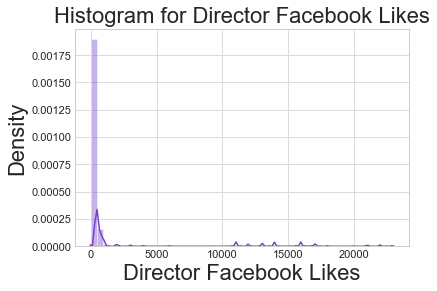

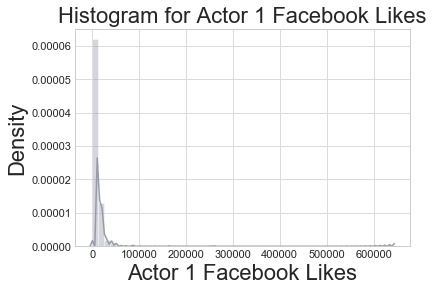

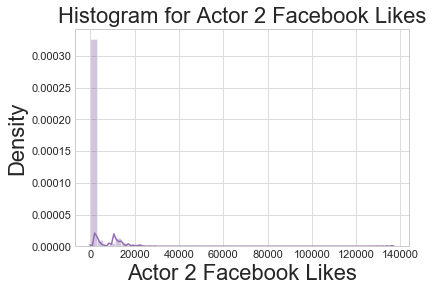

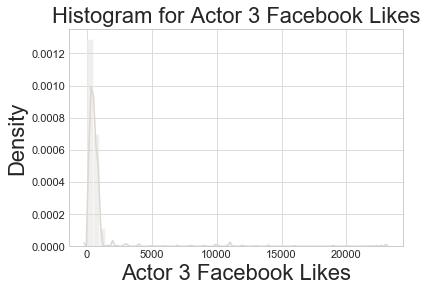

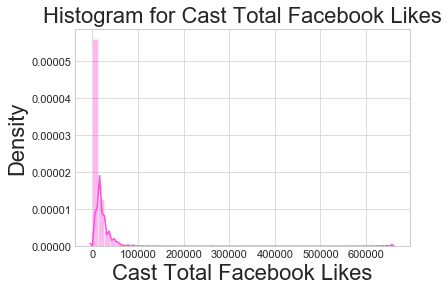

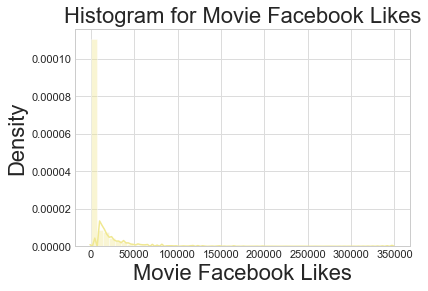

In [15]:
# Check the distribution of the various types of facebook likes. 

for variable in facebook_relation_var:

    series = movie_df[variable].dropna()
    
    # Set up the plot
    ax = sns.distplot(a = series,
                      hist = True, 
                      kde = True, 
                      color = random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_title(f'Histogram for {var_presentation}', size = 22)
    ax.set_xlabel(var_presentation, size = 22)
    ax.set_ylabel('Density', size= 22)

    plt.show()
    
# All facebook likes are highly skewed 
# Actor 1s have the largest fan base
# Movies facebook profiles also do a good job at garnering likes, but not as at a high rate. 

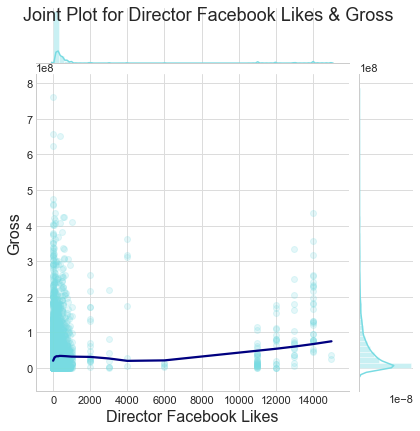

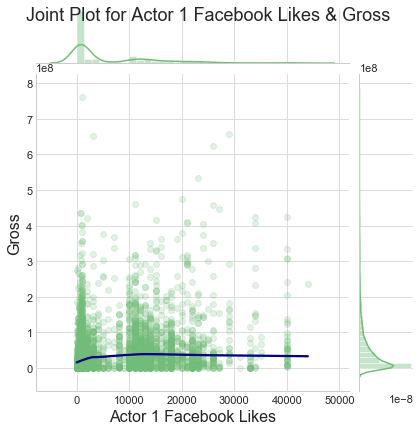

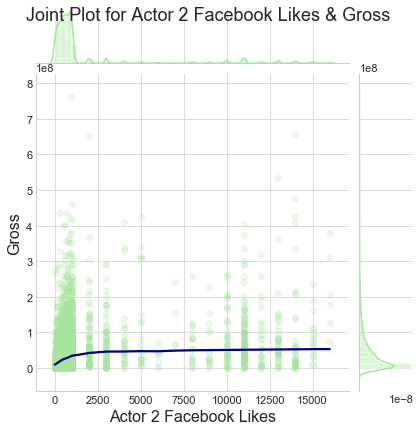

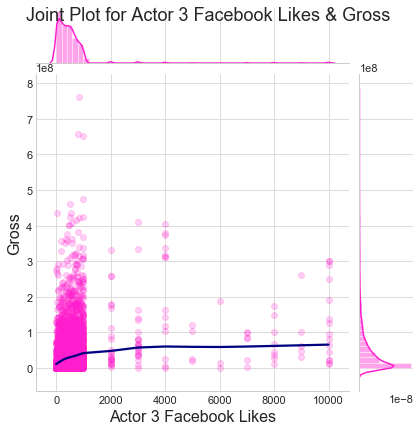

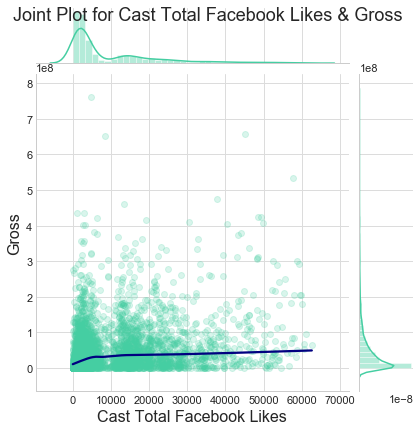

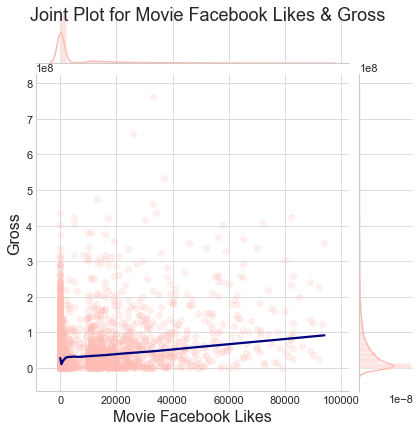

In [16]:
# Check the relationship between the facebook likes and the gross

for variable in facebook_relation_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'gross',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'navy'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'Gross', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & Gross', size = 18)


    plt.show()

# Follows a fairly linear relationship. However there are some outliers. 

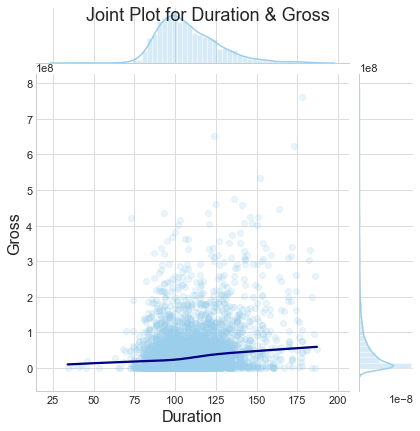

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


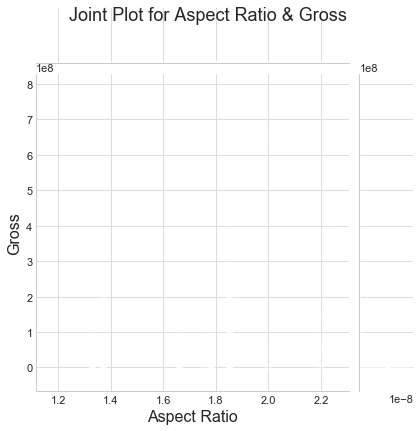

In [17]:
# Check the relationship between the movie specific attributes and votes

for variable in movie_specific_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'gross',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'navy'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'Gross', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & Gross', size = 18)


    plt.show()
    
# Duration vs gross relationship appears to be quadratic 
# Aspect Ratio vs gross relationship appears to be slightly linear (barely noticeable)

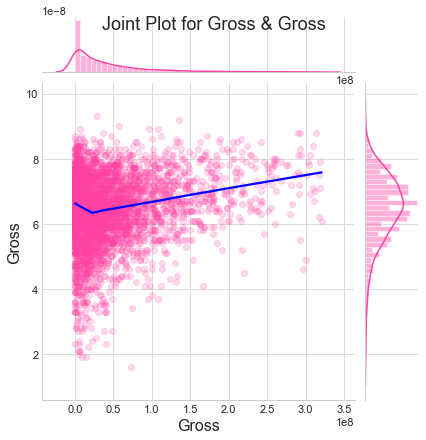

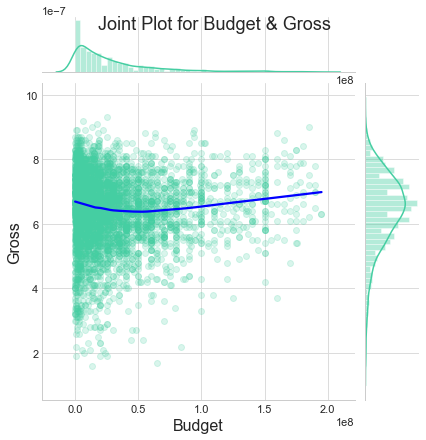

In [18]:
# Check the relationship between the facebook likes and the imdb score

for variable in monetary_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'imdb_score',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'blue'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'Gross', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & Gross', size = 18)


    plt.show()
    
# The duration and the score appears to have a quadratic relationship with a lowess function. 

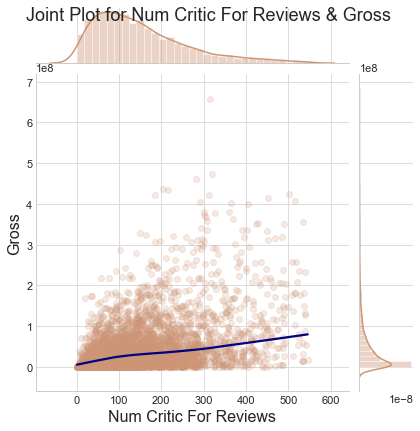

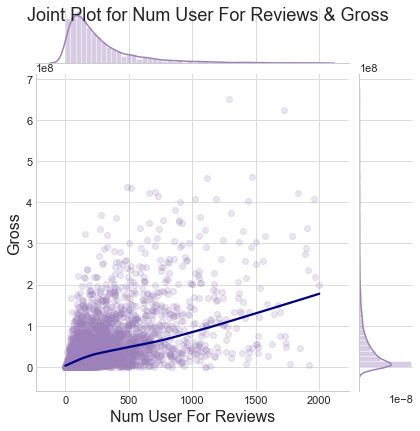

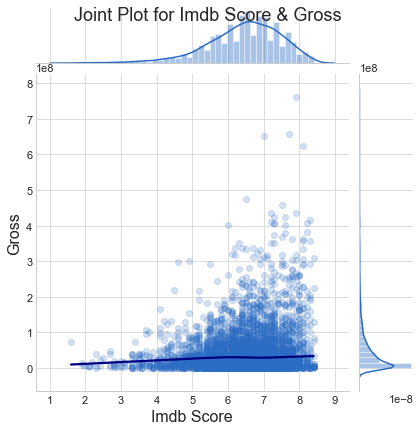

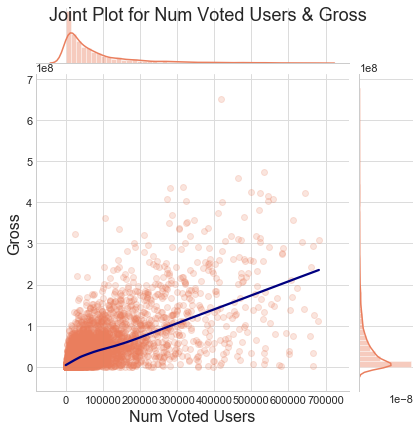

In [19]:
# Check the relationship between the movie specific attributes and votes

for variable in review_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'gross',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'navy'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'Gross', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & Gross', size = 18)


    plt.show()
    
# Num of critic review, user reviews, num voted users appears to be strongly linear 
# The IMDB score appears to have a linear relationship as well. 

Text(0,0.5,'Gross')

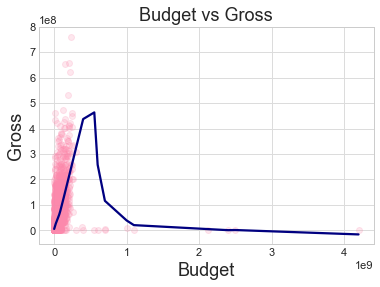

In [20]:
# The budget vs gross relationship appears to be fairly linear, but then goes down after a certain threshold
ax = sns.regplot(x = 'budget',
                 y = 'gross', 
                 data = movie_df[movie_df['budget'] < 1e10], 
                 lowess = True, 
                 line_kws={'color': 'navy'}, 
                 scatter_kws={'alpha':0.2},
                 color= random.choice(available_colors)
                )

ax.set_title('Budget vs Gross',size = 18)
ax.set_xlabel('Budget', fontsize = 18)
ax.set_ylabel('Gross', fontsize = 18)

/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


Text(0,0.5,'Gross')

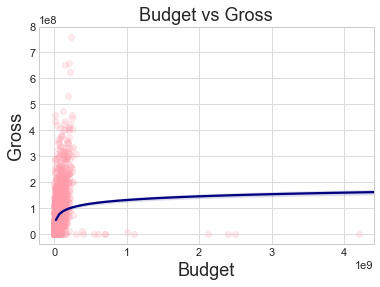

In [21]:
# Let's see what happens if we take the log of x. 
# Taking the logarithm will show the relationship better. 
ax = sns.regplot(x = 'budget',
                 y = 'gross', 
                 data = movie_df[movie_df['budget'] < 1e10], 
                 line_kws={'color': 'navy'},
                 scatter_kws={'alpha':0.2},
                 color= random.choice(available_colors),
                 logx = True
                )

ax.set_title('Budget vs Gross',size = 18)
ax.set_xlabel('Budget', fontsize = 18)
ax.set_ylabel('Gross', fontsize = 18)

Text(0,0.5,'Gross')

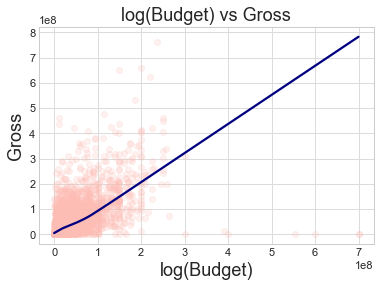

In [22]:
ax = sns.regplot(x = 'budget',
                 y = 'gross', 
                 data = movie_df[movie_df['budget'] < 1e9], 
                 lowess = True, 
                 line_kws={'color': 'navy'},
                 scatter_kws={'alpha':0.2},
                 color= random.choice(available_colors)
                )

ax.set_title('log(Budget) vs Gross',size = 18)
ax.set_xlabel('log(Budget)', fontsize = 18)
ax.set_ylabel('Gross', fontsize = 18)

Text(0,0.5,'Gross')

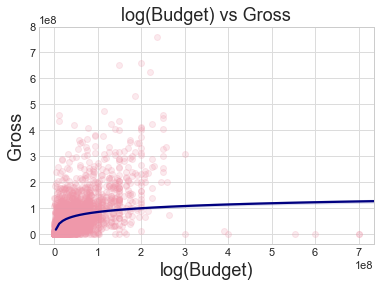

In [23]:
# This relationship may make the most sense. While a budget increase should increase gross earnings, the effect
# is marginal after a certain threshold. 

ax = sns.regplot(x = 'budget',
                 y = 'gross', 
                 data = movie_df[movie_df['budget'] < 1e9], 
                 line_kws={'color': 'navy'},
                 scatter_kws={'alpha':0.2},
                 color= random.choice(available_colors),
                 logx = True
                )
ax.set_title('log(Budget) vs Gross',size = 18)
ax.set_xlabel('log(Budget)', fontsize = 18)
ax.set_ylabel('Gross', fontsize = 18)

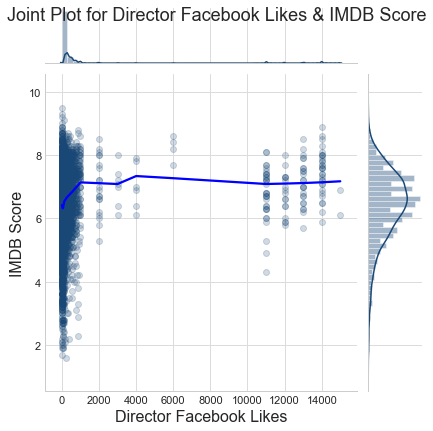

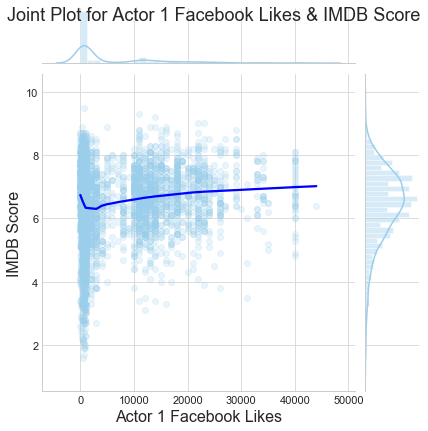

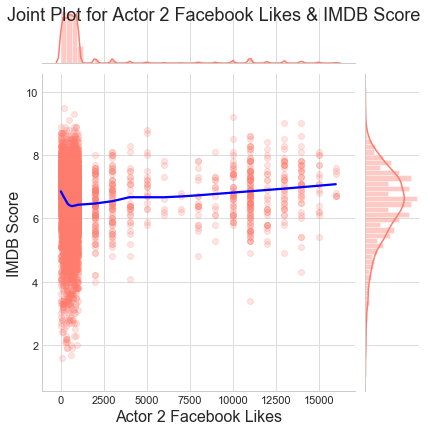

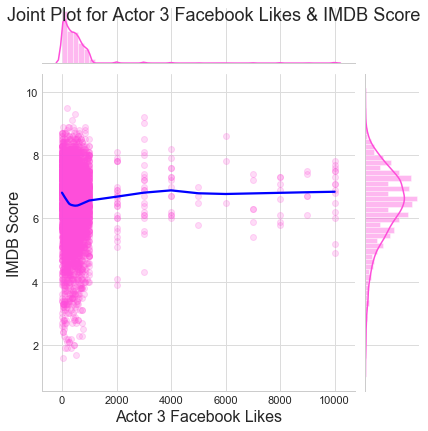

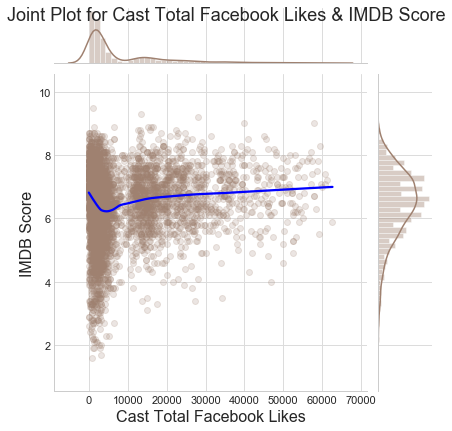

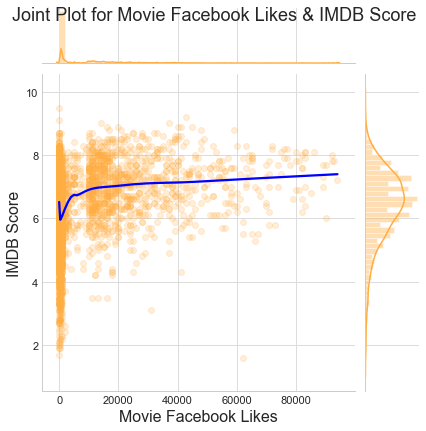

In [24]:
# Check the relationship between the facebook likes and the imdb score

for variable in facebook_relation_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'imdb_score',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'blue'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'IMDB Score', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & IMDB Score', size = 18)


    plt.show()

# Though the relationship isn't strong, it appears that the more likes
# an account has, the higher the imdb score. 
# If an account has 0 facebook likes, the imdb score is a little 
# higher. That could be the average of low and high imdb 
# scores. Without them, the relationship can be random, linear, or logarithmic

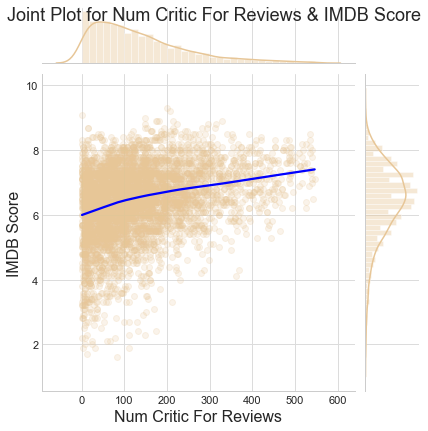

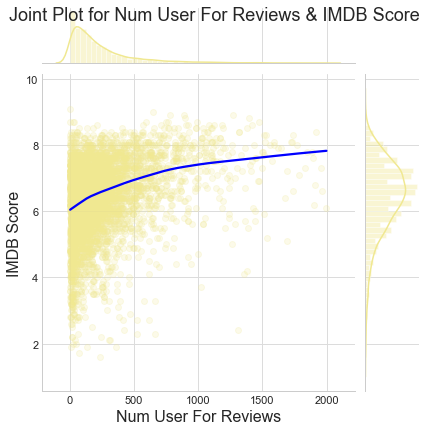

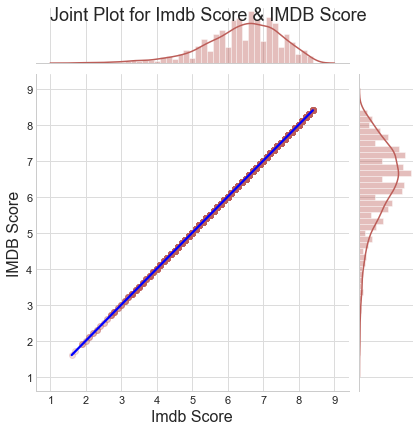

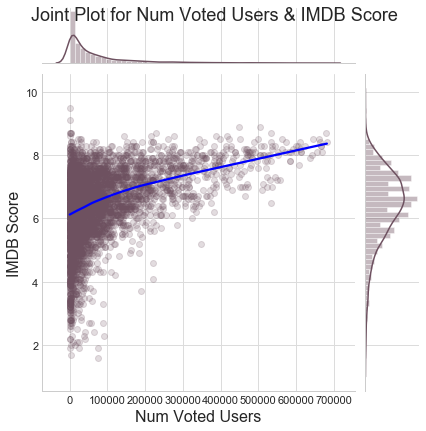

In [25]:
# Check the relationship between the facebook likes and the imdb score

for variable in review_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'imdb_score',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'blue'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'IMDB Score', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & IMDB Score', size = 18)


    plt.show()
    
# The more critics and users for reviews and votes the higher the score 

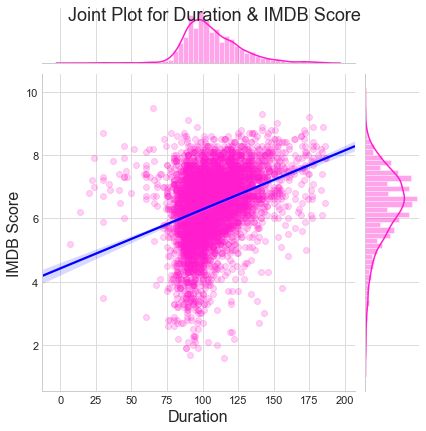

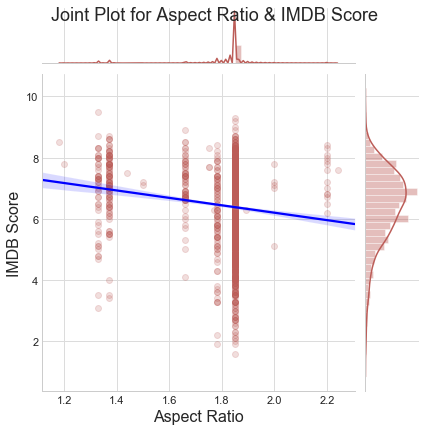

In [26]:
# Check the relationship between the facebook likes and the imdb score

for variable in movie_specific_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'imdb_score',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                     #  lowess = True,
                       line_kws={'color': 'blue'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'IMDB Score', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & IMDB Score', size = 18)


    plt.show()
    
# The duration and the score appears to have a quadratic relationship with a lowess function. 

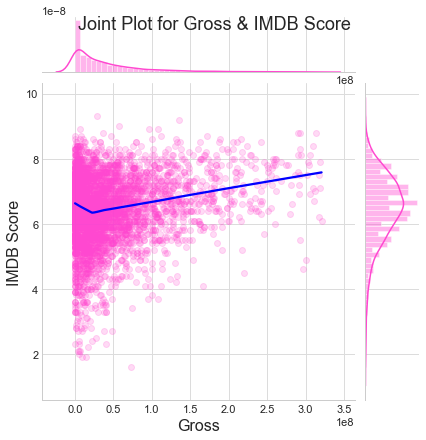

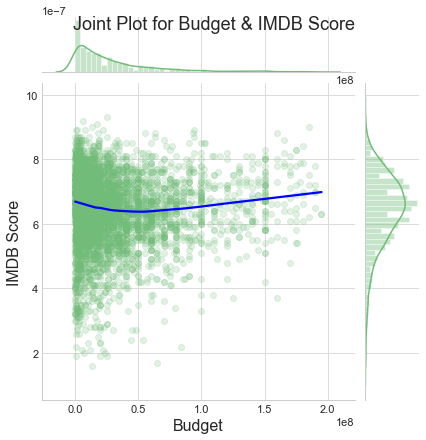

In [27]:
# Check the relationship between the facebook likes and the imdb score

for variable in monetary_var:

    outlier_threshold = movie_df[variable].quantile(q=0.99, interpolation='nearest')    
    
    # Set up the plot
    ax = sns.jointplot(x = variable,
                       y = 'imdb_score',
                       data = movie_df[movie_df[variable] < outlier_threshold],
                       kind = "reg",
                       lowess = True,
                       line_kws={'color': 'blue'},
                       scatter_kws={'alpha':0.2},
                       color= random.choice(available_colors)
                     )

    var_presentation = variable.replace('_', ' ').title()
    
    # Title and labels
    ax.set_axis_labels(var_presentation, 'IMDB Score', fontsize=16)
    fig = ax.fig
    fig.suptitle(f'Joint Plot for {var_presentation} & IMDB Score', size = 18)


    plt.show()
    
# The duration and the score appears to have a quadratic relationship with a lowess function. 

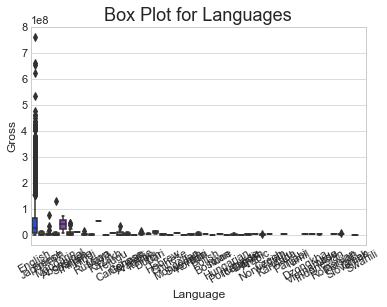

In [28]:
# Let's take a look at the categorical variables 
fig, ax = plt.subplots(1, 1)
sns.catplot(x = "language",
            y = "gross", 
            kind = "box", 
            data = movie_df, 
            palette= random.choice(available_palettes),
            ax = ax)
ax.set_title('Box Plot for Languages', size = 18)
ax.set_xlabel('Language')
ax.set_ylabel('Gross')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.close(2)

# English appears to bring in the most gross earnings. Please note that the results can be biased if it is taken 
# from a small sample or if the sampling technique is biased. 

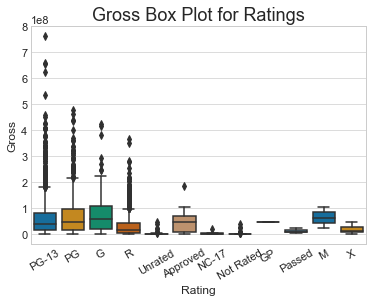

In [29]:
fig, ax = plt.subplots(1, 1)
sns.catplot(x = "content_rating",
            y = "gross", 
            kind = "box",
            data = movie_df,
            palette = random.choice(available_palettes),
            ax = ax
           )
ax.set_title('Gross Box Plot for Ratings', size = 18)
ax.set_xlabel('Rating')
ax.set_ylabel('Gross')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.close(2)

# Ratings catered to a younger audience generally bring in the higher gross earnings

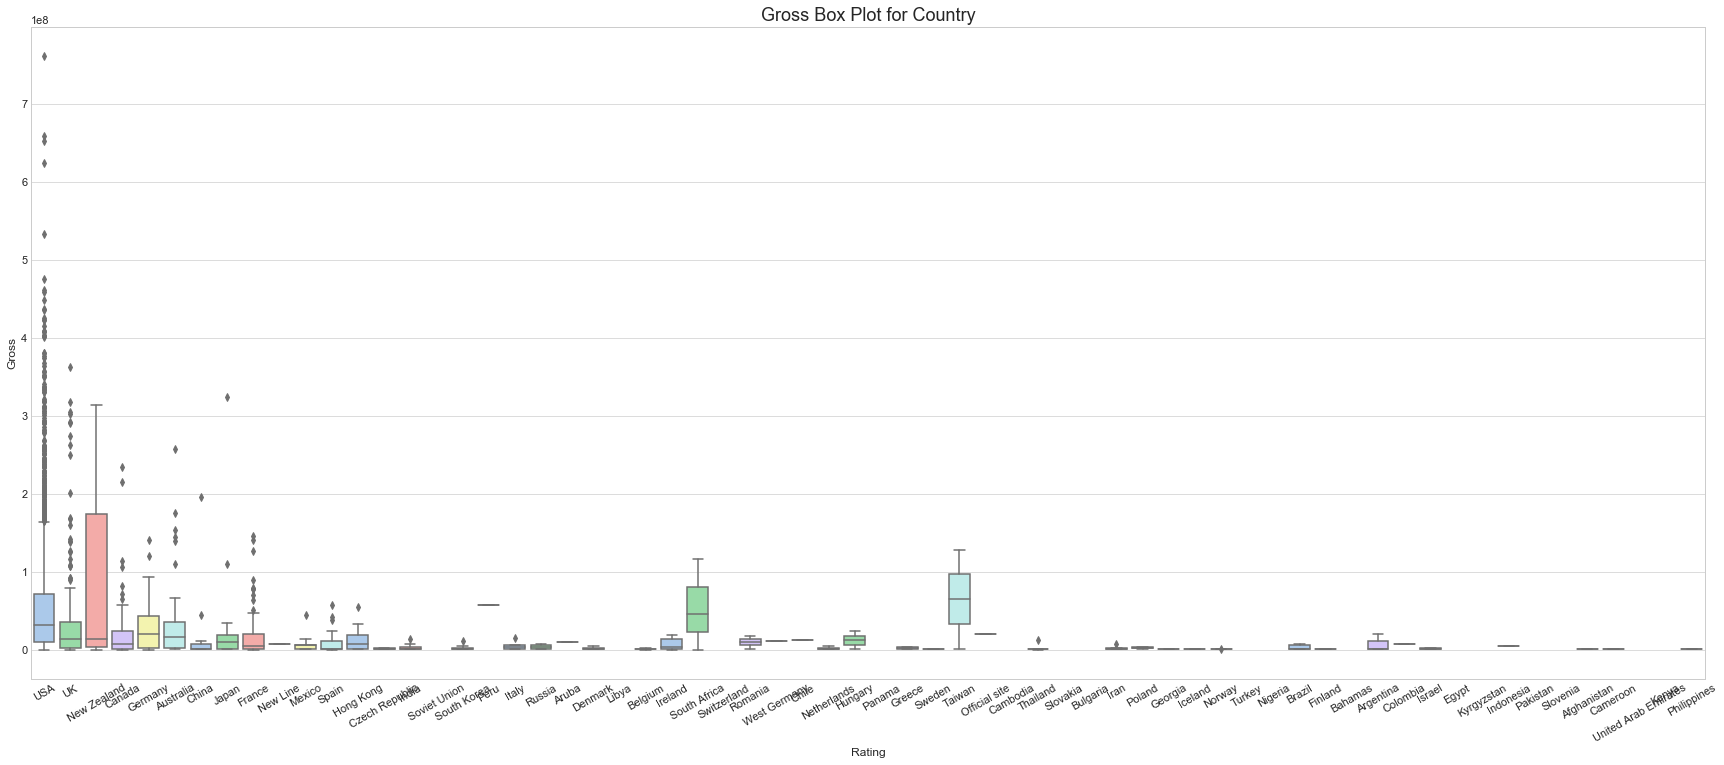

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (30, 12))
sns.catplot(x = "country",
            y = "gross", 
            kind = "box", 
            data = movie_df,
            palette = random.choice(available_palettes),
            ax = ax
           )
ax.set_title('Gross Box Plot for Country', size = 18)
ax.set_xlabel('Rating')
ax.set_ylabel('Gross')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.close(2)

# Movies from the US have the most outliers and the most success. Movies from New Zealand can also be lucrative. 

In [31]:
# I want to take a closer look at the genres. They are currently formulated as 'genre1|genre2|genre3'
# Need to separate them out into their own separate columns 
# https://stackoverflow.com/questions/50069693/split-column-into-unknown-number-of-columns-by-delimiter-pandas

# Get dummy variables for genres
genres_df =  movie_df.genres.str.get_dummies(sep='|')

# Create a list of dummy variables
genres_columns = list(genres_df.columns)

# Concatenate DFs together
movie_df = pd.concat(objs = [movie_df, genres_df], axis = 1)

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


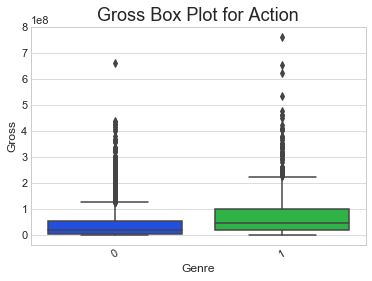

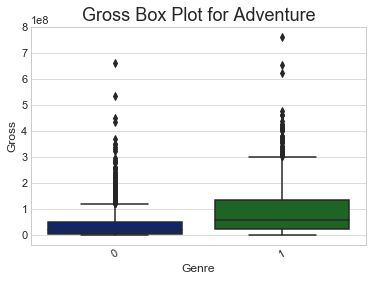

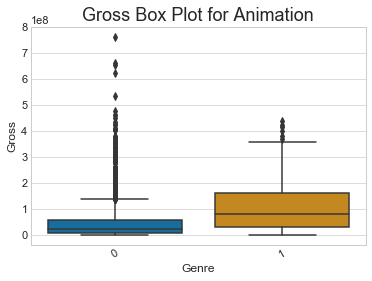

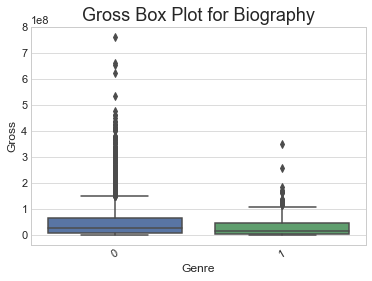

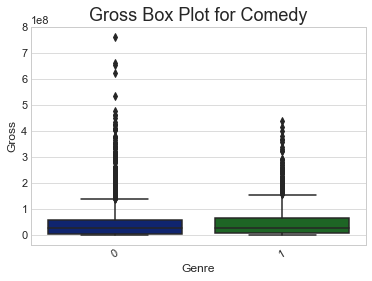

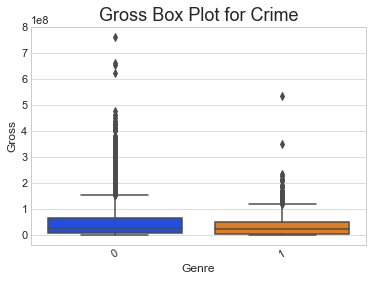

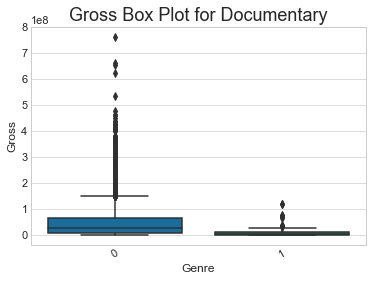

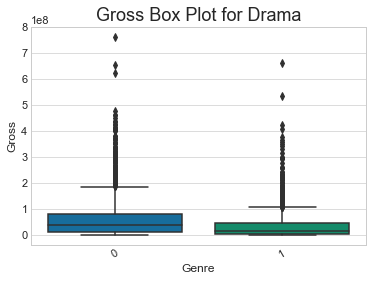

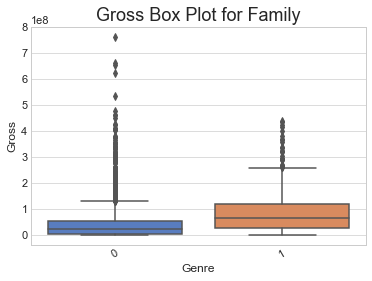

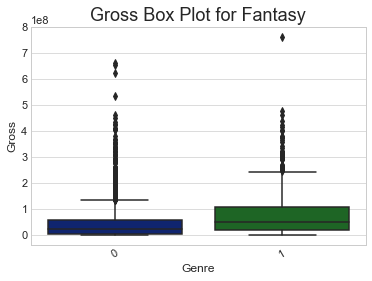

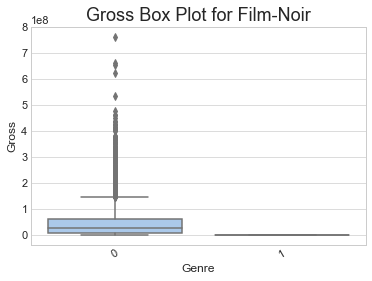

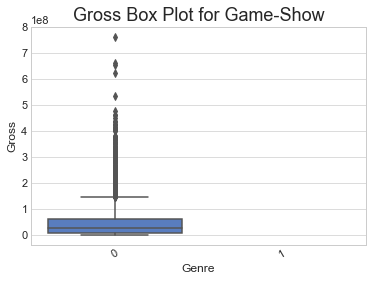

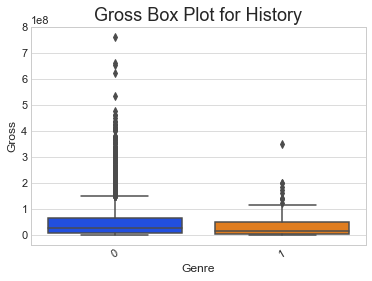

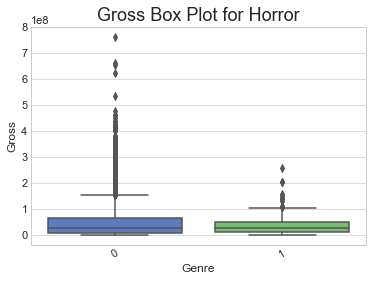

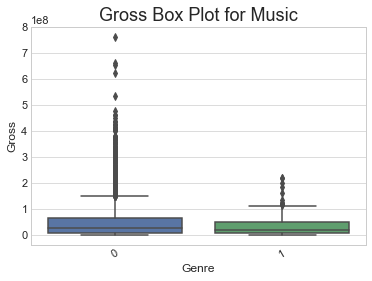

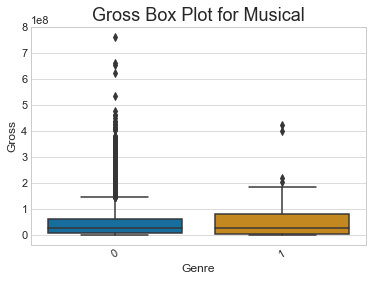

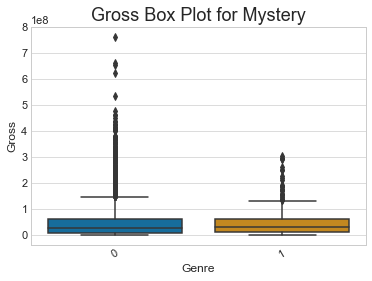

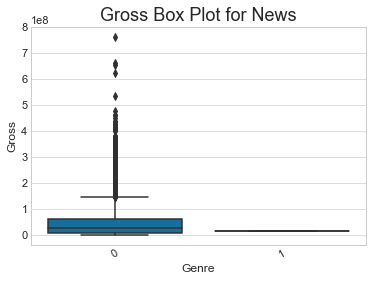

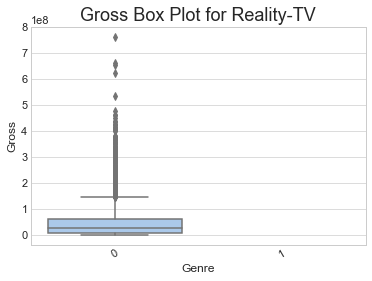

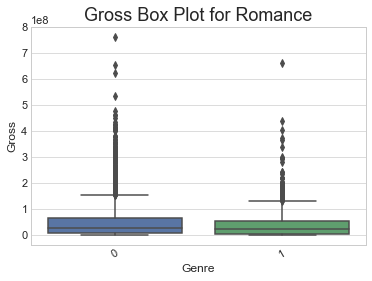

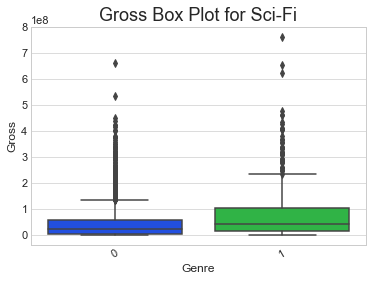

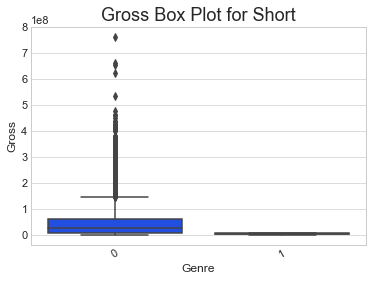

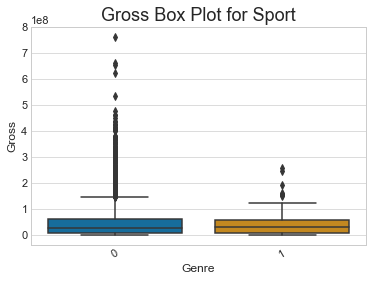

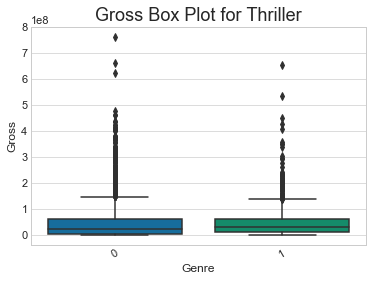

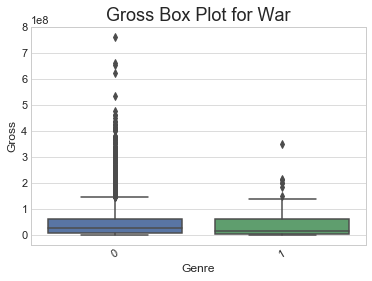

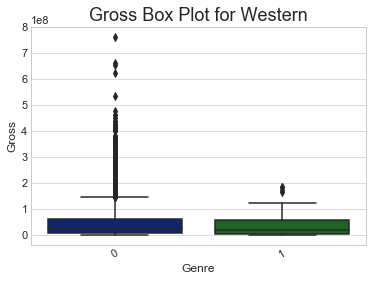

In [32]:
for genre in genres_columns: 
    
    fig, ax = plt.subplots(1, 1)
    
    sns.boxplot(x = genre,
                y = "gross",
                data = movie_df,
                palette = random.choice(available_palettes),
                ax = ax
               )
    
    ax.set_title(f'Gross Box Plot for {genre}', size = 18)
    ax.set_xlabel('Genre')
    ax.set_ylabel('Gross')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    
# Action, Adventure, Animation, Crime (slightly), Family, Fantasy, Musical, Sci-fi have higher IQR. 
# The others are either worse or do not have too much information to make an informed decision. 

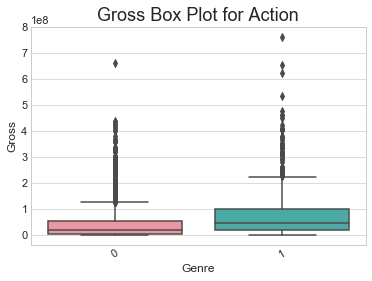

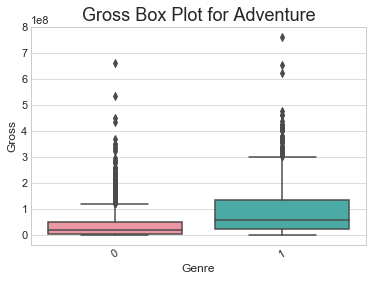

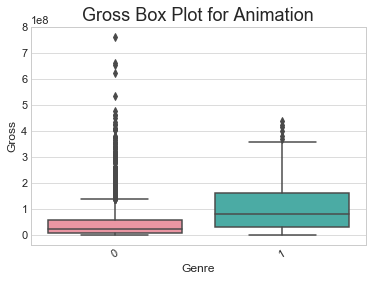

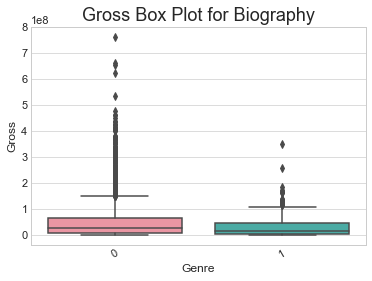

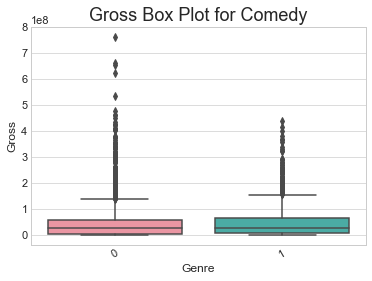

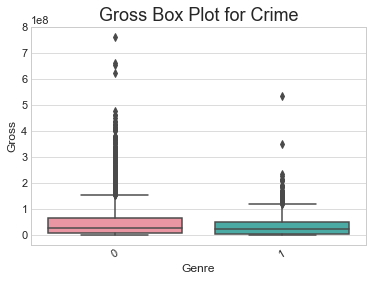

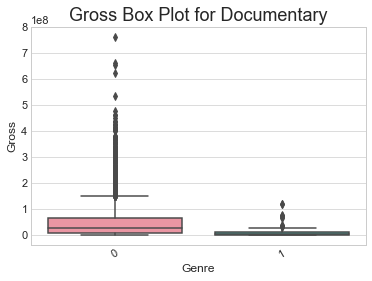

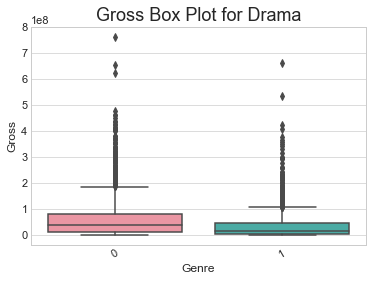

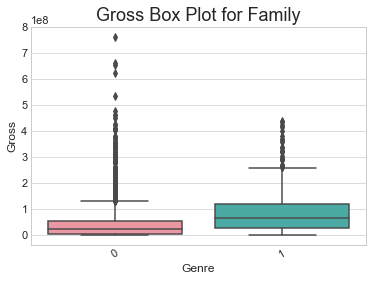

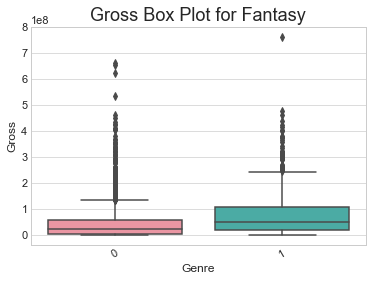

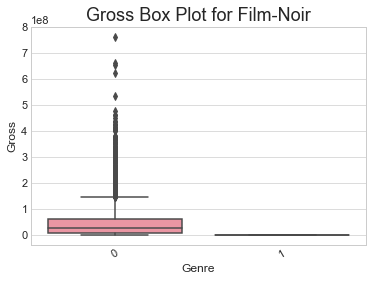

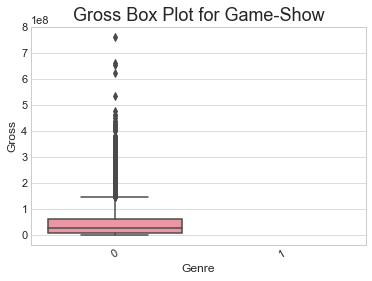

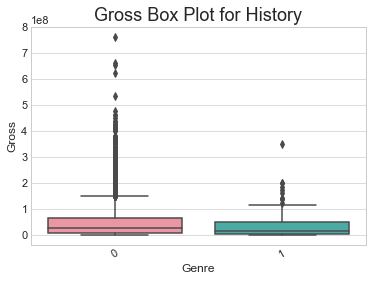

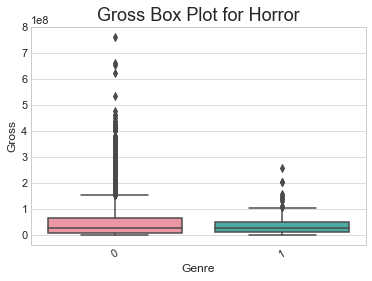

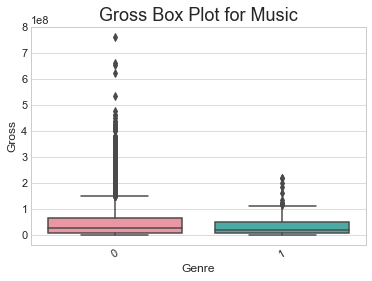

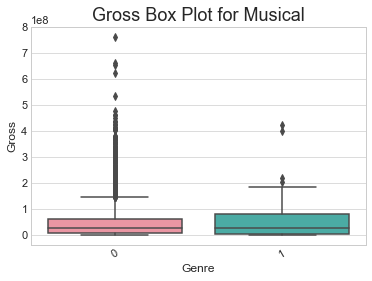

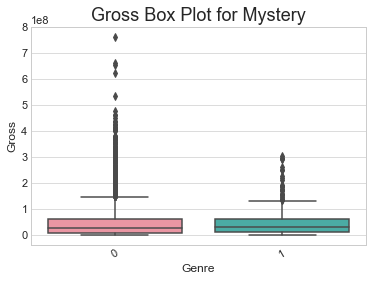

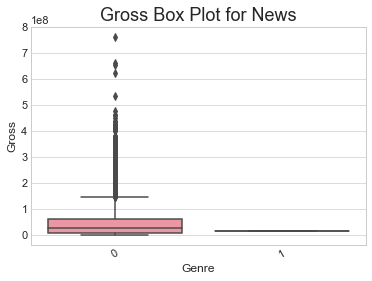

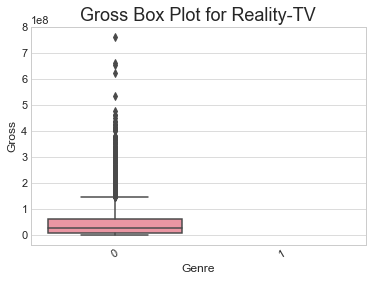

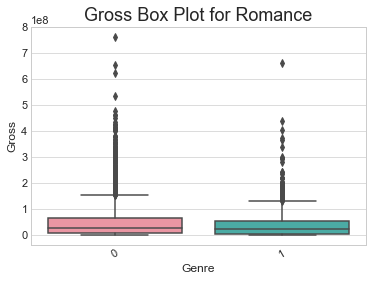

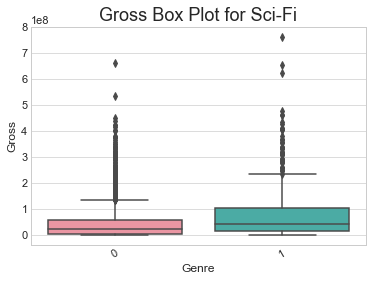

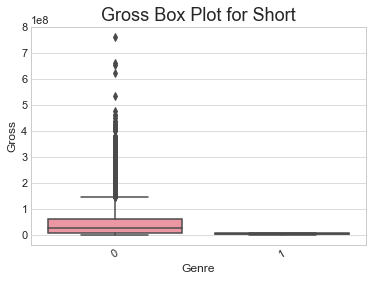

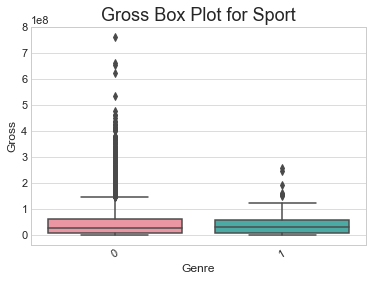

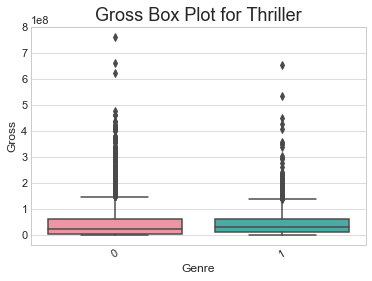

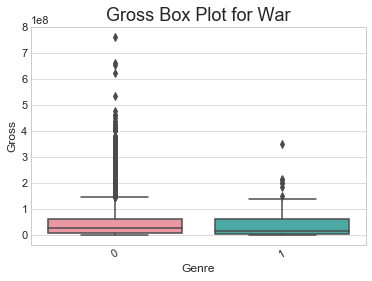

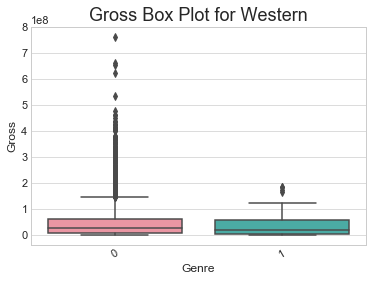

In [33]:
for genre in genres_columns: 
    
    fig, ax = plt.subplots(1, 1)
    
    sns.boxplot(x = genre, y = "gross", data = movie_df, ax = ax)
    
    ax.set_title(f'Gross Box Plot for {genre}', size = 18)
    ax.set_xlabel('Genre')
    ax.set_ylabel('Gross')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    
# Action, Adventure, Animation, Crime (slightly), Family, Fantasy, Musical, Sci-fi have higher IQR. 
# The others are either worse or do not have too much information to make an informed decision. 

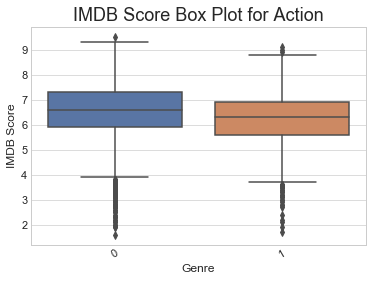

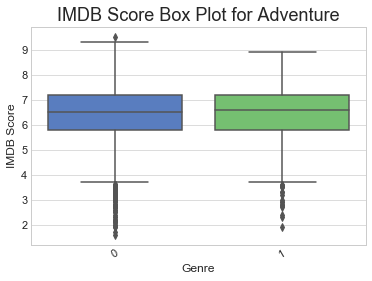

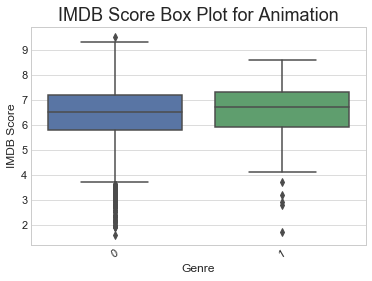

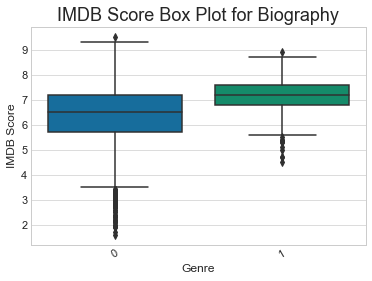

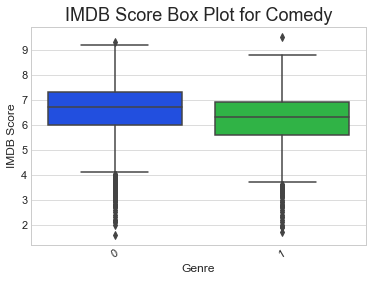

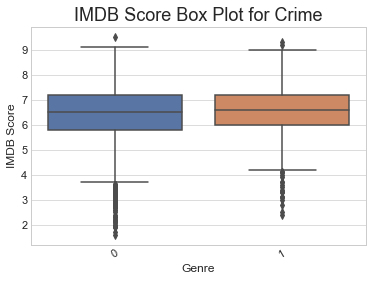

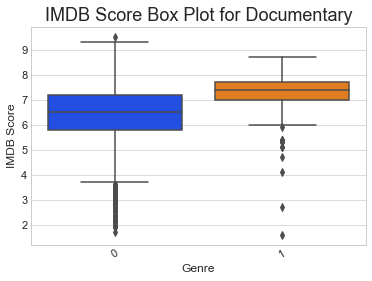

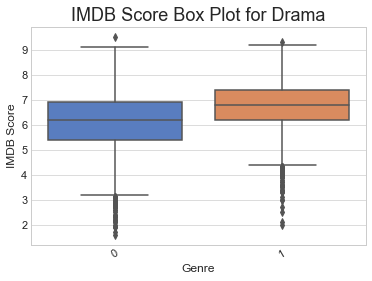

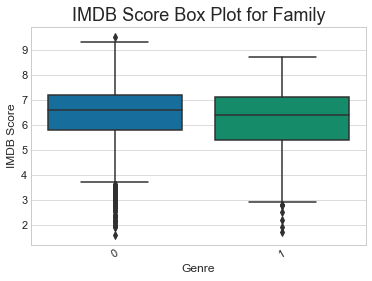

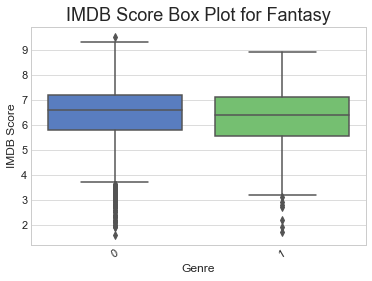

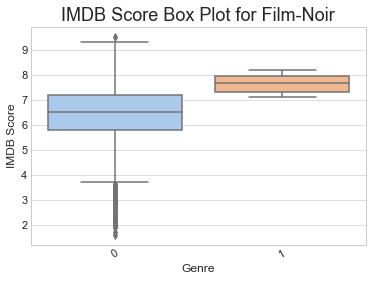

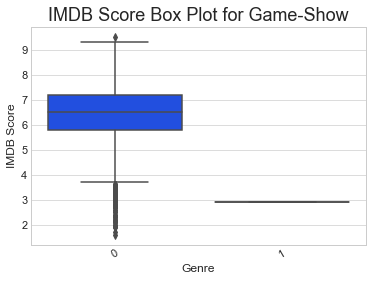

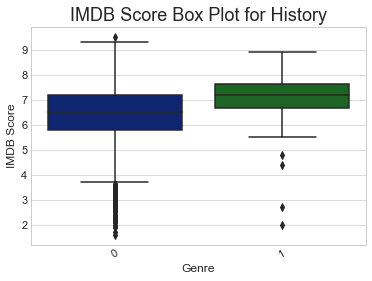

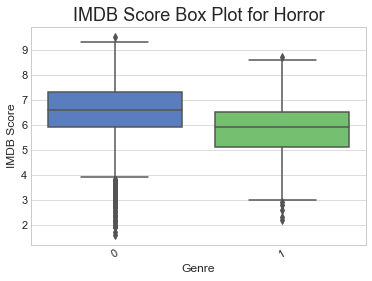

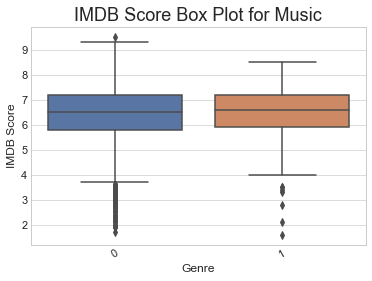

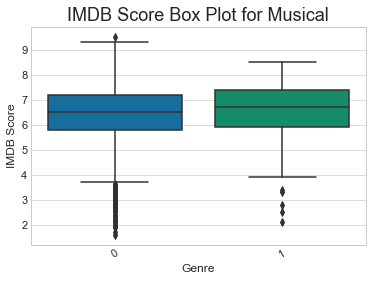

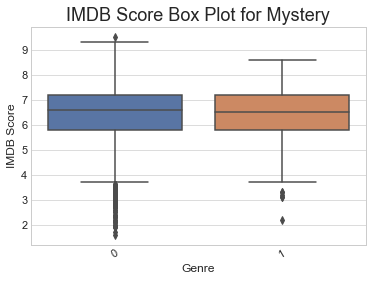

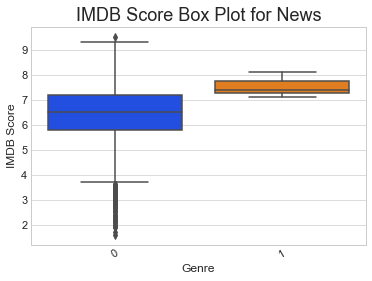

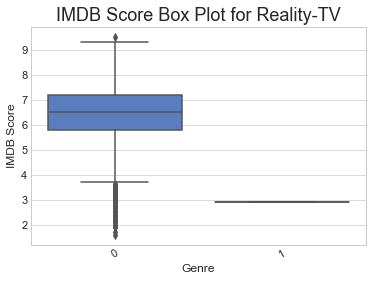

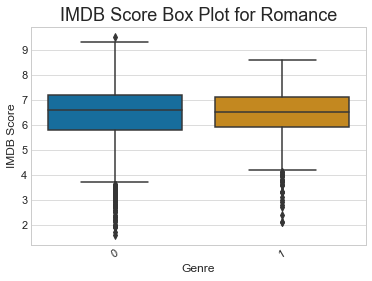

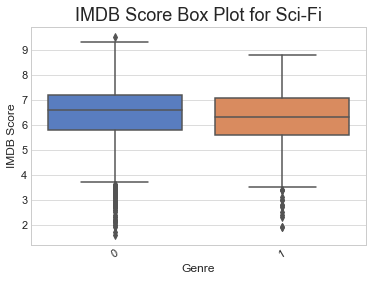

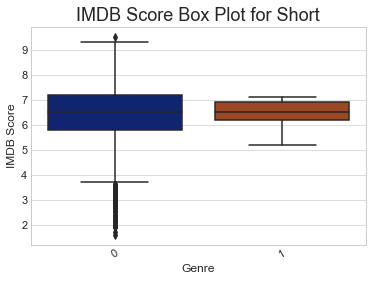

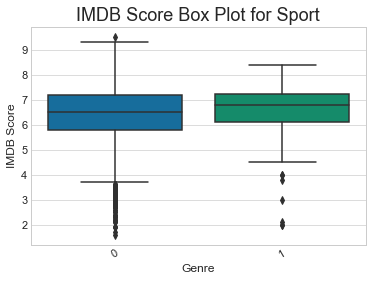

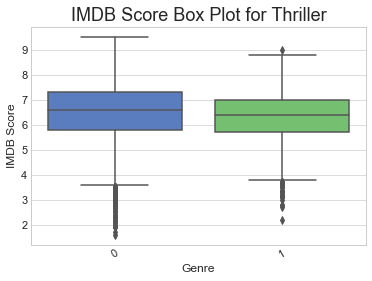

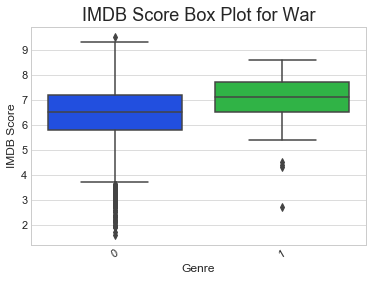

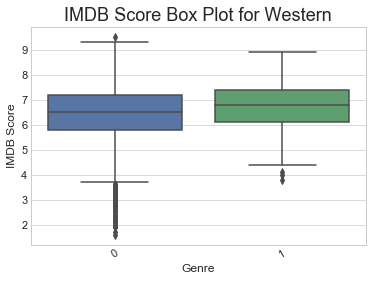

In [34]:
for genre in genres_columns: 
    
    fig, ax = plt.subplots(1, 1)
    
    sns.boxplot(x = genre,
                y = "imdb_score",
                data = movie_df,
                palette = random.choice(available_palettes),
                ax = ax
               )
    
    ax.set_title(f'IMDB Score Box Plot for {genre}', size = 18)
    ax.set_xlabel('Genre')
    ax.set_ylabel('IMDB Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    
# Ratings for popular genres do not always guarantee a high IMDB score.

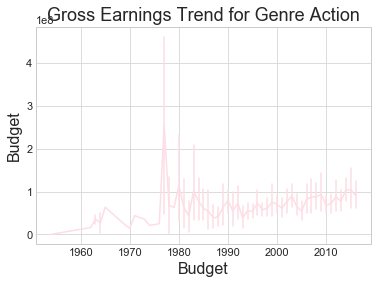

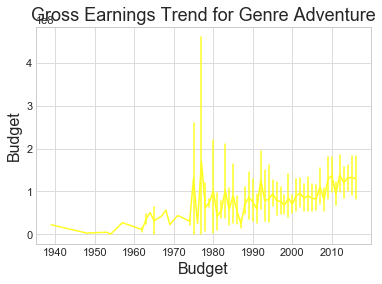

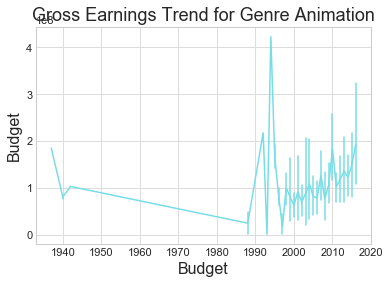

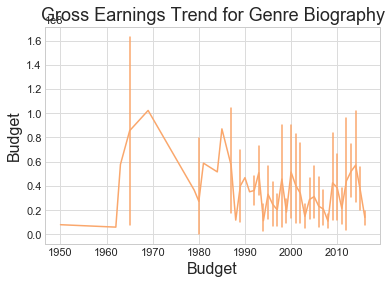

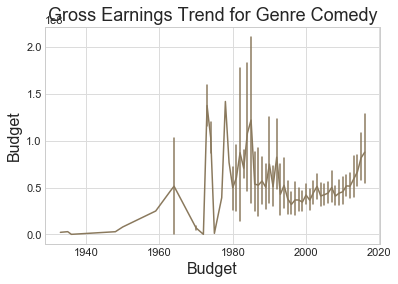

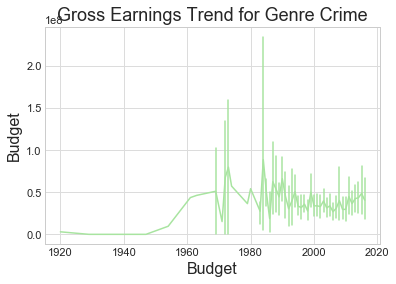

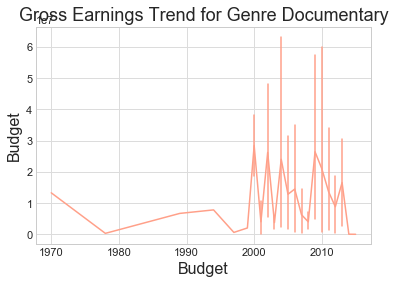

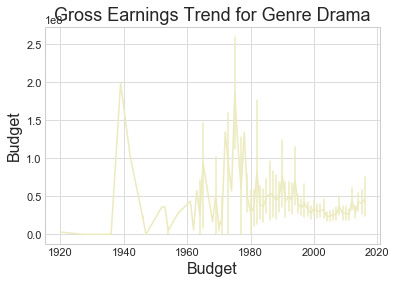

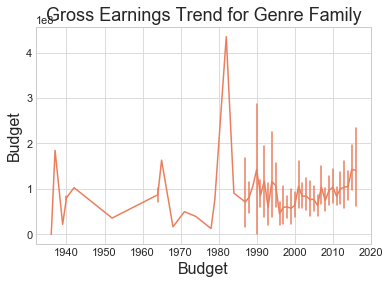

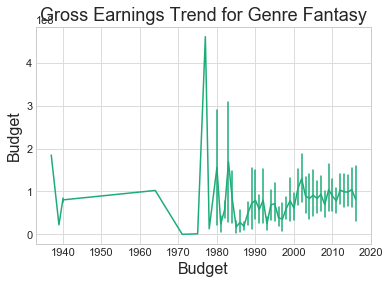

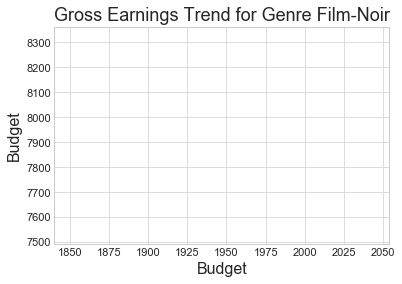

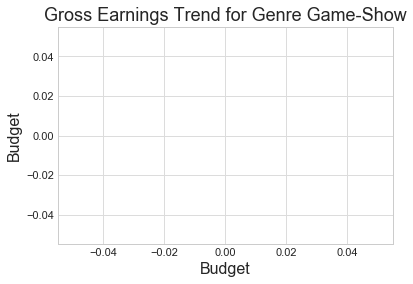

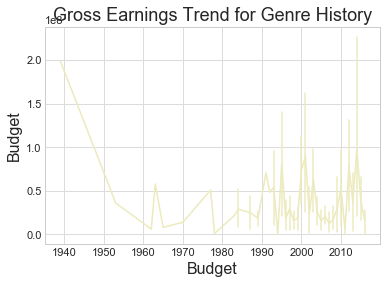

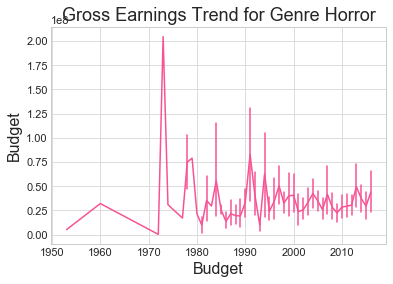

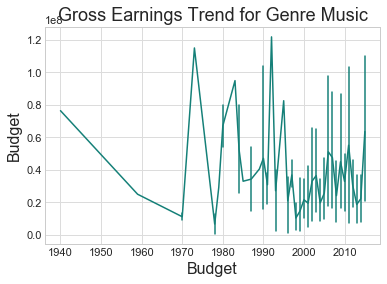

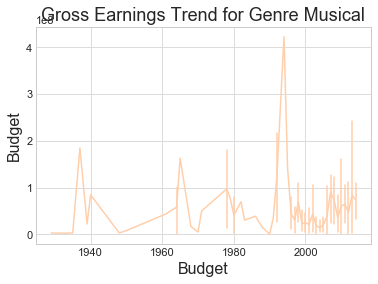

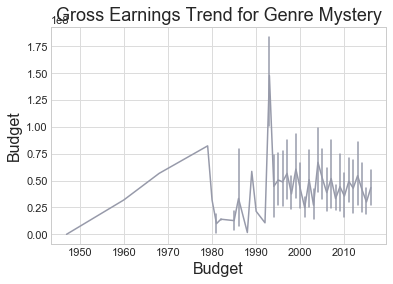

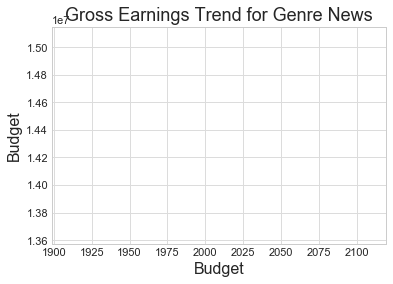

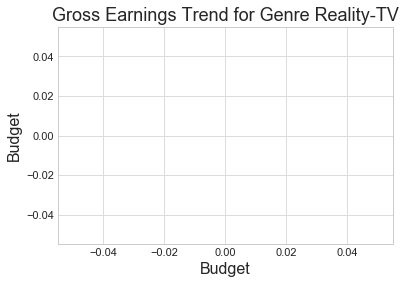

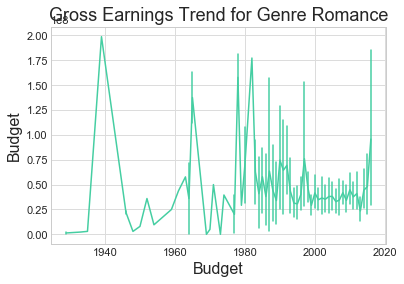

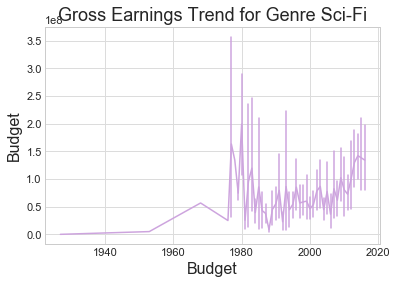

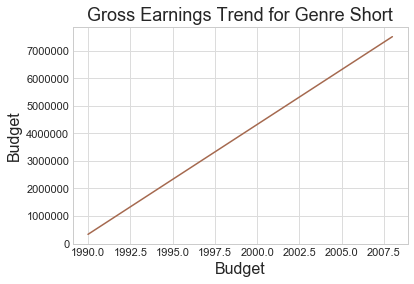

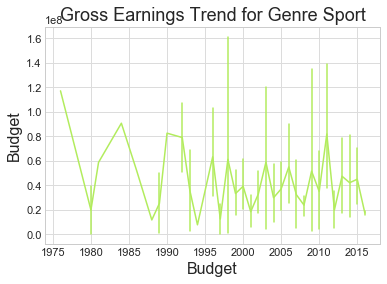

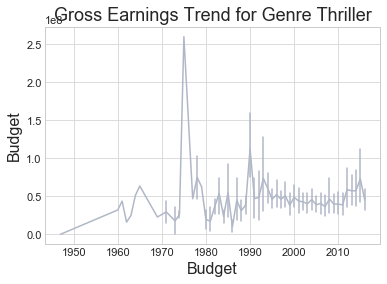

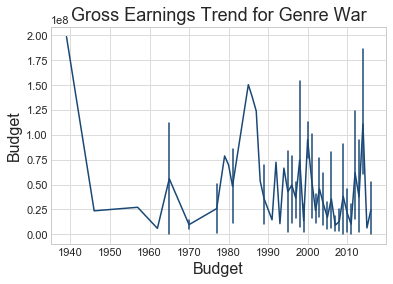

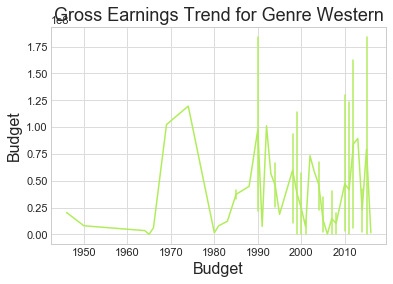

In [35]:
for genre in genres_columns: 

    genre_specific_df = movie_df[movie_df[genre] == 1]

    # Set up the plot

    ax = sns.lineplot(x = "title_year", 
                      y = "gross", 
                      err_style = "bars", 
                      ci = 95, 
                      data = genre_specific_df,
                      color = random.choice(available_colors)

                     )


    var_presentation = variable.replace('_', ' ').title()

    # Title and labels
    ax.set_xlabel(var_presentation, fontsize=16)
    ax.set_ylabel(var_presentation, fontsize=16)
    ax.set_title(f'Gross Earnings Trend for Genre {genre}', size = 18)

    plt.show()

# The more critics and users for reviews and votes the higher the score 

Text(0.5,1,'Gross Earnings for the Most Popular Movies')

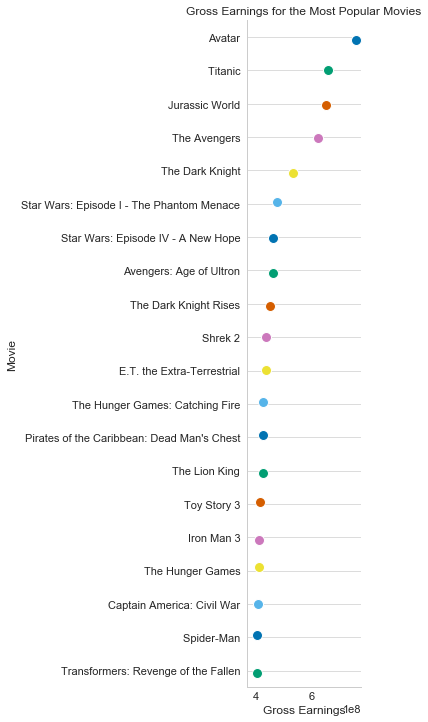

In [36]:
# Take a look at lollipop graphs

# Make the PairGrid
ax = sns.PairGrid(data = movie_df.sort_values("gross", ascending=False).head(20),
                 x_vars = 'gross',
                 y_vars = ["movie_title"],
                 height = 10,
                 aspect=.25
                )

# Draw a dot plot using the stripplot function
ax.map(sns.stripplot, 
      size=10, 
      orient="h",
      palette=random.choice(available_palettes),
      linewidth=1, 
      edgecolor="w"
     )

ax.axes.flat[0].yaxis.grid(True)
ax.axes.flat[0].xaxis.grid(False)
ax.axes.flat[0].set_ylabel('Movie')
ax.axes.flat[0].set_xlabel('Gross Earnings')
ax.axes.flat[0].set_title('Gross Earnings for the Most Popular Movies')

In [37]:
# Look at revenue / budget ratio
# Helps us look at the return on investment (ROI) for the movie
# The larger the number, the more successful it is

movie_df['roi'] = movie_df['gross'] / movie_df['budget']

Text(0.5,1,'Earnings/Budget Ratios for Top Movies')

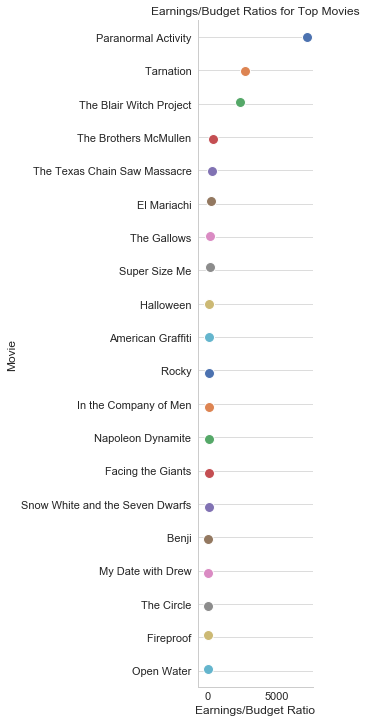

In [38]:
# Take a look at lollipop graphs

# Make the PairGrid
ax = sns.PairGrid(data = movie_df.sort_values("roi", ascending=False).head(20),
                 x_vars = 'roi',
                 y_vars = ["movie_title"],
                 height = 10,
                 aspect=.25
                )

# Draw a dot plot using the stripplot function
ax.map(sns.stripplot, 
      size=10, 
      orient="h",
      palette=random.choice(available_palettes),
      linewidth=1, 
      edgecolor="w"
     )

ax.axes.flat[0].yaxis.grid(True)
ax.axes.flat[0].xaxis.grid(False)
ax.axes.flat[0].set_ylabel('Movie')
ax.axes.flat[0].set_xlabel('Earnings/Budget Ratio')
ax.axes.flat[0].set_title('Earnings/Budget Ratios for Top Movies')